In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vit-soil/vit_transformer_module.py
/kaggle/input/for-training/engine.py
/kaggle/input/soil-image-classification/test/Alluvial soil/es-alluvial-soil-01c.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/Alluvial-Soil.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/An-example-of-a-soil-profile-from-a-well-drained-alluvial-fan-in-the-Atacama-Desert.png
/kaggle/input/soil-image-classification/test/Alluvial soil/AlluvialsoilsRicker4Alluvium_LandUse1200x630.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/38.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/th4.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/OIP.95L3kBHrnJiscNzRwQgmlgHaDW.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/Alluvial-Soil..png
/kaggle/input/soil-image-classification/test/Alluvial soil/alluvial-deposits-david-parkerscience-photo-library.jpg
/kaggle/input/soil-image-classification/test/Alluvial soil/th9.jpg
/kaggle/inp

In [2]:
!python --version

Python 3.10.12


In [3]:
import torch
torch.__version__

'2.5.1+cu121'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from torchvision import models

In [6]:
train_dir="/kaggle/input/soil-image-classification/train_data"
test_dir="/kaggle/input/soil-image-classification/test"

In [7]:
#  Create Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Less aggressive cropping (90-100% scaling)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Fixed missing bracket
])

In [9]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=train_transforms,
    test_transform=test_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names



(<torch.utils.data.dataloader.DataLoader at 0x78ca71836cb0>,
 ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil'])

torch.Size([3, 224, 224]) tensor(3)


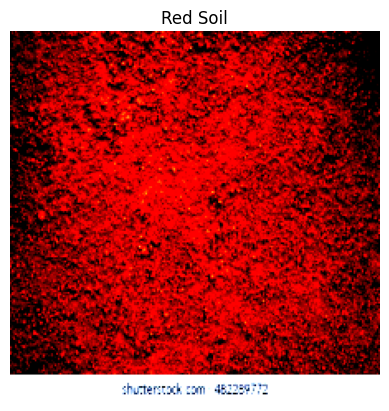

In [10]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [11]:
# Load Pretrained ViT Model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)  # Load pretrained weights  # Load pretrained weights
num_ftrs = model.heads.head.in_features  # Get input features of the classifier head
num_classes = len(class_names)  # Use number of classes in your dataset

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 82.7MB/s] 


In [12]:
import torch.optim as optim

# Modify the Classifier Head (Better Regularization)
model.heads.head = nn.Sequential(
    nn.LayerNorm(num_ftrs),  # LayerNorm for stability
    nn.Dropout(0.5),  # Increased dropout for stronger regularization
    nn.Linear(num_ftrs, 256),  # Smaller intermediate layer
    nn.GELU(),  # Activation
    nn.LayerNorm(256),  # LayerNorm for stability
    nn.Dropout(0.3),  # Increased dropout
    nn.Linear(256, num_classes)  # Final classification layer
)
# Optimizer with Stronger Regularization
optimizer = optim.AdamW([
    {"params": model.encoder.layers[-5:].parameters(), "lr": 1e-5},  
    {"params": model.heads.head.parameters(), "lr": 3e-5}  
], weight_decay=1e-3)  # Increased weight decay

# Learning Rate Scheduler (Slower Decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.5
)

In [13]:
# Print model summary
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [14]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, scheduler=None, epochs=10, save_path="best_model.pth"):
    model.to(device)
    train_accs, test_accs = [], []
    best_acc = 0.0
    best_model_wts = None
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total * 100
        train_accs.append(train_acc)
        
         # Evaluate on validation data
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total * 100
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, save_path)
            print(f"New best model saved with Test Acc: {best_acc:.2f}%")
        
        if scheduler:
            scheduler.step(100 - test_acc)

    print(f"\nBest Model Test Accuracy: {best_acc:.2f}%")
    return best_model_wts, train_accs, test_accs

def plot_accuracy(train_accs, test_accs, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_accs, label="Train Accuracy", marker='o', linestyle='-')
    plt.plot(range(1, epochs + 1), test_accs, label="Test Accuracy", marker='o', linestyle='-')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Testing Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
criterion = torch.nn.CrossEntropyLoss()
best_model_wts, train_accs, test_accs = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, device, scheduler, epochs=15)

Epoch [1/15], Train Acc: 40.52%, Test Acc: 65.82%
New best model saved with Test Acc: 65.82%
Epoch [2/15], Train Acc: 58.60%, Test Acc: 77.22%
New best model saved with Test Acc: 77.22%
Epoch [3/15], Train Acc: 69.39%, Test Acc: 87.34%
New best model saved with Test Acc: 87.34%
Epoch [4/15], Train Acc: 77.55%, Test Acc: 94.94%
New best model saved with Test Acc: 94.94%
Epoch [5/15], Train Acc: 79.88%, Test Acc: 94.94%
Epoch [6/15], Train Acc: 84.84%, Test Acc: 94.94%
Epoch [7/15], Train Acc: 87.76%, Test Acc: 94.94%
Epoch [8/15], Train Acc: 86.01%, Test Acc: 95.57%
New best model saved with Test Acc: 95.57%
Epoch [9/15], Train Acc: 90.09%, Test Acc: 94.30%
Epoch [10/15], Train Acc: 88.63%, Test Acc: 93.67%
Epoch [11/15], Train Acc: 90.67%, Test Acc: 94.30%
Epoch [12/15], Train Acc: 91.25%, Test Acc: 94.30%
Epoch [13/15], Train Acc: 91.84%, Test Acc: 94.30%
Epoch [14/15], Train Acc: 89.80%, Test Acc: 94.30%
Epoch [15/15], Train Acc: 93.00%, Test Acc: 94.30%

Best Model Test Accuracy: 95

In [16]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

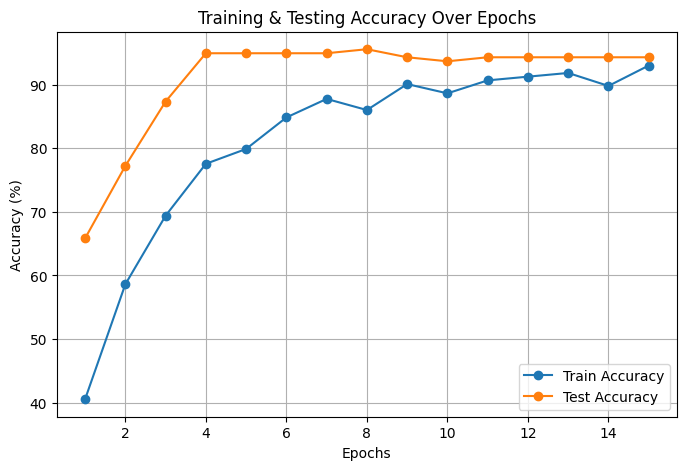

In [17]:
# Plot accuracy curves
plot_accuracy(train_accs, test_accs, epochs=15)

In [25]:
# 1️⃣ Reinitialize the model with the same architecture
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)  # Load pretrained model
model.heads.head = nn.Sequential(
    nn.LayerNorm(num_ftrs),  # LayerNorm for stability
    nn.Dropout(0.5),  # Increased dropout for stronger regularization
    nn.Linear(num_ftrs, 256),  # Smaller intermediate layer
    nn.GELU(),  # Activation
    nn.LayerNorm(256),  # LayerNorm for stability
    nn.Dropout(0.3),  # Increased dropout
    nn.Linear(256, num_classes)  # Final classification layer
)
model.to(device)

# 2️⃣ Load the saved state_dict (weights)
best_model_wts = torch.load("/kaggle/working/best_model.pth", map_location=device)  # Load weights
model.load_state_dict(best_model_wts)  # ✅ Load weights into model

model.eval()  # Set model to evaluation mode


<ipython-input-25-ff190cbc5900>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_wts = torch.load("/kaggle/working/best_model.pth", map_location=device)  # Load 

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [26]:
import torchvision.transforms as transforms
from PIL import Image
# 1️⃣ Define Image Transformations (Same as Training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize (adjust if different in training)
])

# 2️⃣ Load the Image
image_path = "/kaggle/input/red-soil-img/red-soil-bdbe44d01e-800x530.webp"  # Change to your image file
image = Image.open(image_path).convert("RGB")  # Convert to RGB (in case it's grayscale)
image = transform(image)  # Apply transformations
image = image.unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

# 3️⃣ Move to GPU if available
image = image.to(device)
model.to(device)

# 4️⃣ Pass the Image Through the Model
with torch.no_grad():  # No need to calculate gradients for inference
    outputs = model(image)

# 5️⃣ Get Predicted Class
_, predicted_class = torch.max(outputs, 1)  # Get index of highest probability

# 6️⃣ Define Class Labels (Update According to Your Dataset)
class_names = ["Alluvial", "Black", "Clay", "Red"]  # Change as per your dataset
predicted_label = class_names[predicted_class.item()]

# 7️⃣ Print the Result
print(f"Predicted Soil Type: {predicted_label}")


Predicted Soil Type: Red


In [ ]:
import requests

API_KEY = "f344fb6a066b314bb008dfed9b003715ffedad233902dc939db558d9b46d6..."  # Replace with your Together AI API key
url = "https://api.together.xyz/v1/chat/completions"

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}


In [28]:
state = input("Enter State in India: ")
season = input("Enter Season: ")
soil_type=predicted_label
query_text = f"The soil is {soil_type}. State in India is {state}. Season is {season}. Suggest best crops to grow."

data = {
    "model": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free",
    "messages": [{"role": "user", "content": query_text}]
}

response = requests.post(url, headers=headers, json=data)

Enter State in India:  Tamil Nadu
Enter Season:  Summer


In [30]:
import re
if response.status_code == 200:
    response_text = response.json()["choices"][0]["message"]["content"]
    cleaned_text = re.sub(r"<think>.*?</think>", "", response_text, flags=re.DOTALL).strip()
    
    print("\nLLM Response:", cleaned_text)
  # Extracting only the useful response
else:
    print(f"Error {response.status_code}: {response.text}")


LLM Response: In Tamil Nadu, India, during the summer season, the best crops to grow in red soil, considering high temperatures and potential water scarcity, are:

1. **Millets**: 
   - **Pearl Millet (Bajra)**: Drought-tolerant and matures quickly.
   - **Sorghum (Jowar)**: Dual-purpose for food and fodder, with fast growth.

2. **Pulses**:
   - **Red Gram (Toor Dal)**: Tolerates dry conditions and enriches soil.
   - **Cowpea**: Grows well in poor soil and high temperatures.

3. **Oilseeds**:
   - **Groundnut (Peanut)**: Fixes nitrogen, suitable for red soil.
   - **Sunflower**: Thrives in well-drained soil, good for oil extraction.

4. **Vegetables** (if irrigation is available):
   - **Chilies**: High market value and relatively low water needs.
   - **Tomatoes**: Profitable but require more care and water.

**Additional Considerations**:
- **Soil Preparation**: Enhance fertility with organic matter.
- **Water Management**: Prioritize drought-resistant varieties and efficient irri

In [31]:
crop = input("Enter the crop you want to grow: ")
query_text = f"The soil is {soil_type}. State in India is {state}. Season is {season}. Crop is {crop}.Tell me the nutrients , fertilizers and other things required by me to do to grow this crop"

data = {
    "model": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B-free",
    "messages": [{"role": "user", "content": query_text}]
}

response = requests.post(url, headers=headers, json=data)

Enter the crop you want to grow:  Sunflower


In [32]:
if response.status_code == 200:
    response_text = response.json()["choices"][0]["message"]["content"]
    cleaned_text = re.sub(r"<think>.*?</think>", "", response_text, flags=re.DOTALL).strip()
    
    print("\nLLM Response:", cleaned_text)
  # Extracting only the useful response
else:
    print(f"Error {response.status_code}: {response.text}")


LLM Response: To grow sunflowers in Tamil Nadu during the summer on red soil, follow this organized plan:

### Soil Preparation
1. **Soil Testing**: Test the pH of the red soil. Sunflowers prefer a pH of 6.0 to 7.0. Adjust pH if necessary using lime to raise it or organic matter to lower it.
2. **Organic Matter**: Incorporate compost or well-rotted manure to improve soil structure and nutrient content. Aim for about 5-10% organic matter in the soil.

### Nutrient Management
1. **Fertilizers**:
   - **Basal Dose**: Apply a balanced fertilizer (10:10:10 NPK) at 50 kg/acre or 12.5 kg/ha.
   - **Top Dressing**: After 30 days, apply Urea (46:0:0) at 25 kg/acre or 6.25 kg/ha for nitrogen.
   - **Phosphorus and Potassium**: Apply DAP (18:46:0) at 50 kg/acre or 12.5 kg/ha and MOP (0:0:60) at 25 kg/acre or 6.25 kg/ha as a basal dose.

### Irrigation
1. **Water Management**: Use drip irrigation for efficiency. Water deeply but less frequently to encourage deep root growth, especially during flo